In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA

In [2]:
data = pd.read_csv("2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv")

In [3]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",291.02,294,294.42,290.26,47.00M,-0.76%
1,"Mar 30, 2021",293.25,294.86,295.72,291.5,38.81M,-0.02%
2,"Mar 29, 2021",293.3,289.72,294.09,289.26,43.68M,0.71%
3,"Mar 26, 2021",291.22,288.63,292.75,288.32,56.07M,1.59%
4,"Mar 25, 2021",286.66,286.5,287.03,283.85,35.22M,0.30%


In [4]:
data.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        1
Change %    1
dtype: int64

In [5]:
data.tail()

,Date,Price,Open,High,Low,Vol.,Change %
307,"Jan 09, 2020",257.99,259.4,261.76,257.01,38.33M,-0.45%
308,"Jan 08, 2020",259.15,253.57,259.15,253.03,40.82M,2.07%
309,"Jan 06, 2020",253.9,254.75,254.84,251.4,22.35M,-0.43%
310,"Jan 03, 2020",255,255.99,258.19,253.7,35.85M,0.10%
311,Highest: 296.07,Lowest: 172.15,Difference: 123.92,Average: 234.52,Change %: 14.24,NaN,NaN


In [6]:
data = data.iloc[:-1,:]

In [7]:
data.shape

(311, 7)

In [8]:
#don't use year as feature, as new incoming data will be future year which the trained model would not have seen

In [9]:
%time data['Date'] = data.Date.apply(lambda x: datetime.datetime.strptime(x, '%b %d, %Y'))

CPU times: user 8.44 ms, sys: 2.43 ms, total: 10.9 ms
Wall time: 11.1 ms


In [10]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.week
data['Day'] = data['Date'].dt.day
data['Dayofweek'] = data['Date'].dt.dayofweek

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
data

,Date,Price,Open,High,Low,Vol.,Change %,Year,Month,Week,Day,Dayofweek
0,2021-03-31,291.02,294,294.42,290.26,47.00M,-0.76%,2021,3,13,31,2
1,2021-03-30,293.25,294.86,295.72,291.5,38.81M,-0.02%,2021,3,13,30,1
2,2021-03-29,293.3,289.72,294.09,289.26,43.68M,0.71%,2021,3,13,29,0
3,2021-03-26,291.22,288.63,292.75,288.32,56.07M,1.59%,2021,3,12,26,4
4,2021-03-25,286.66,286.5,287.03,283.85,35.22M,0.30%,2021,3,12,25,3
...,...,...,...,...,...,...,...,...,...,...,...,...
306,2020-01-10,258.19,257.86,259.25,256.88,18.85M,0.08%,2020,1,2,10,4
307,2020-01-09,257.99,259.4,261.76,257.01,38.33M,-0.45%,2020,1,2,9,3
308,2020-01-08,259.15,253.57,259.15,253.03,40.82M,2.07%,2020,1,2,8,2
309,2020-01-06,253.9,254.75,254.84,251.4,22.35M,-0.43%,2020,1,2,6,0


In [12]:
import warnings
warnings.filterwarnings("ignore")

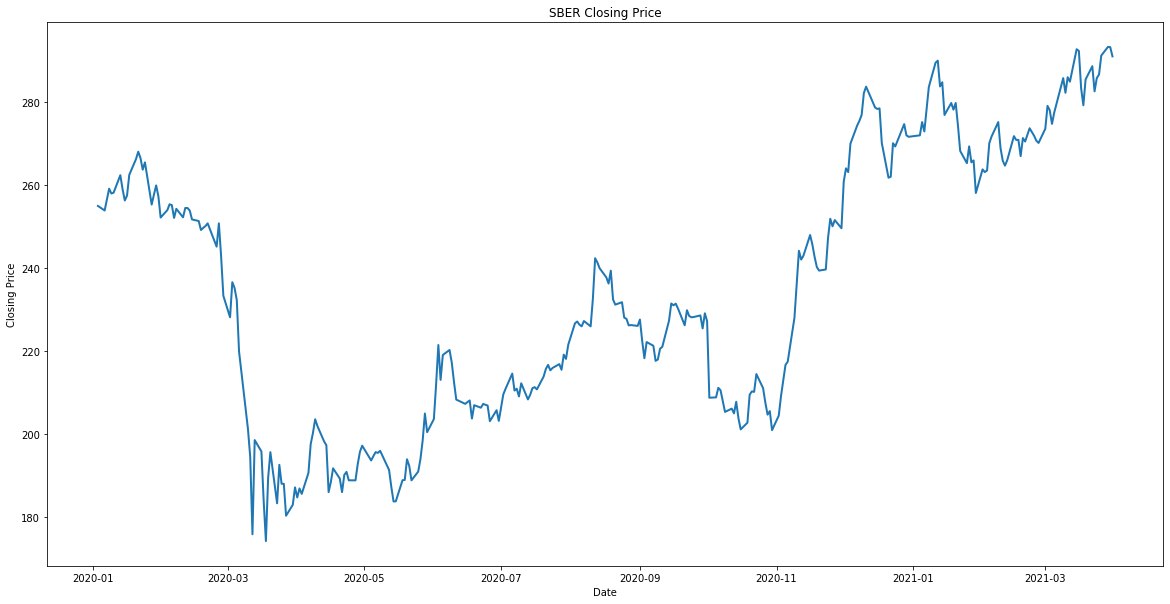

In [13]:
plt.figure(figsize=(20,10))
#plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(data['Date'],data["Price"].astype(float),linewidth=2, markersize=12)
plt.title('SBER Closing Price')
#ay = plt.gca()
#ay.set_ylim([150, 300])
#plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

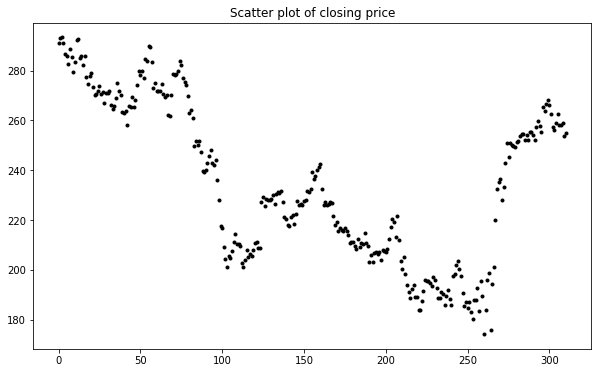

In [14]:
plt.figure(figsize=(10,6))
data['Price'].astype(float).plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

### ARIMA

In [15]:
data1 = data[['Date', 'Price']]

In [16]:
data1.head()

,Date,Price
0,2021-03-31,291.02
1,2021-03-30,293.25
2,2021-03-29,293.3
3,2021-03-26,291.22
4,2021-03-25,286.66


In [17]:
data1['Price'] = data.Price.astype(float)

In [18]:
data1['Date']=pd.to_datetime(data1['Date'])

In [19]:
data1.set_index('Date',inplace=True)

In [20]:
data1.astype(float).describe()

,Price
count,311.000000
mean,234.524019
std,32.079847
min,174.270000
25%,207.700000
50%,229.140000
75%,264.380000
max,293.300000


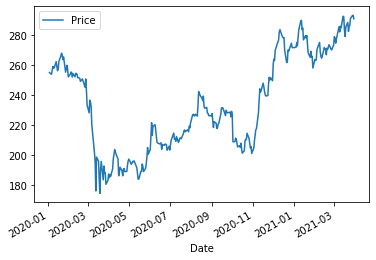

In [21]:
data1.plot()

In [22]:
#Testing if data is Stationary (p > 0.05, non stationary)

from statsmodels.tsa.stattools import adfuller

In [23]:
adtest_result=adfuller(data1['Price'])

In [24]:
def adfuller_test(price):
    result=adfuller(price)
    labels = ['ADF Test Statistic','p-value','No of Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")    

In [25]:
adfuller_test(data1['Price'])

ADF Test Statistic : -1.8471820740476115
p-value : 0.35730124412210584
No of Lags Used : 8
Number of Observations Used : 302
Data is non-stationary 


In [26]:
#To make data stationary we use difference, shifting one position of the data

In [27]:
data1['Price First Difference'] = data1['Price'] - data1['Price'].shift(1)

In [28]:
data1['Price'].shift(1)

Date
2021-03-31       NaN
2021-03-30    291.02
2021-03-29    293.25
2021-03-26    293.30
2021-03-25    291.22
               ...  
2020-01-10    262.40
2020-01-09    258.19
2020-01-08    257.99
2020-01-06    259.15
2020-01-03    253.90
Name: Price, Length: 311, dtype: float64

In [29]:
data1.head()

,Price,Price First Difference
Date,,
2021-03-31,291.02,NaN
2021-03-30,293.25,2.23
2021-03-29,293.30,0.05
2021-03-26,291.22,-2.08
2021-03-25,286.66,-4.56


In [30]:
adfuller_test(data1['Price First Difference'].dropna())

ADF Test Statistic : -5.811293515994707
p-value : 4.3951775754216564e-07
No of Lags Used : 7
Number of Observations Used : 302
Data is stationary


In [15]:
train_data = data.loc[data['Year']==2020]
test_data = data.loc[data['Year']==2021]

In [16]:
print(train_data.Year.value_counts())
print(test_data.Year.value_counts())

2020    250
Name: Year, dtype: int64
2021    61
Name: Year, dtype: int64


In [17]:
train_data.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Year',
       'Month', 'Week', 'Day', 'Dayofweek'],
      dtype='object')

In [18]:
#train_data.drop(['Date','Open','High','Low','Vol.','Change %','Year'],axis=1, inplace=True)

In [30]:
train_data

,Date,Price,Open,High,Low,Vol.,Change %,Year,Month,Week,Day,Dayofweek
61,2020-12-30,271.65,272.49,274.24,270.12,31.53M,-0.13%,2020,12,53,30,2
62,2020-12-29,272,275.91,276.43,271.26,39.02M,-0.98%,2020,12,53,29,1
63,2020-12-28,274.7,270.9,275.19,269.73,39.04M,1.50%,2020,12,53,28,0
64,2020-12-25,270.64,269.97,271,268.28,11.99M,0.49%,2020,12,52,25,4
65,2020-12-24,269.32,271.98,272.82,267.13,42.61M,-0.29%,2020,12,52,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...
306,2020-01-10,258.19,257.86,259.25,256.88,18.85M,0.08%,2020,1,2,10,4
307,2020-01-09,257.99,259.4,261.76,257.01,38.33M,-0.45%,2020,1,2,9,3
308,2020-01-08,259.15,253.57,259.15,253.03,40.82M,2.07%,2020,1,2,8,2
309,2020-01-06,253.9,254.75,254.84,251.4,22.35M,-0.43%,2020,1,2,6,0


In [20]:
#test_data.drop(['Date','Open','High','Low','Vol.','Change %','Year'],axis=1, inplace=True)

In [21]:
#test_data

In [22]:
x_train = train_data[['Month', 'Week', 'Day', 'Dayofweek']].reset_index(drop=True)
y_train = train_data['Price'].reset_index(drop=True)

In [23]:
x_test = test_data[['Month', 'Week', 'Day', 'Dayofweek']].reset_index(drop=True)
y_test = test_data['Price'].reset_index(drop=True)

In [24]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((250, 4), (250,), (61, 4), (61,))

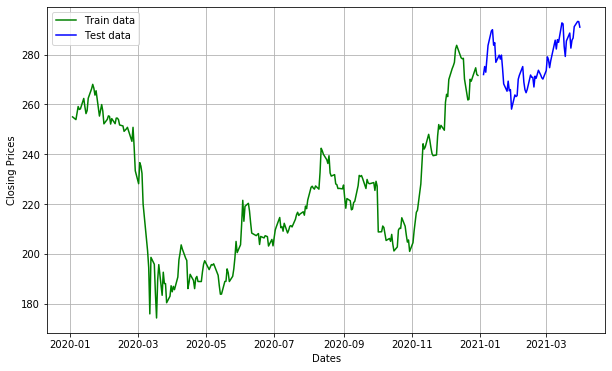

In [25]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data['Date'],train_data['Price'].astype(float), 'green', label='Train data')
plt.plot(test_data['Date'],test_data['Price'].astype(float), 'blue', label='Test data')
plt.legend()

In [26]:
from pmdarima.arima import ARIMA

In [28]:
from pmdarima.arima import auto_arima

In [32]:
model_ARIMA = auto_arima(train_data['Price'], start_p=0, start_q=0,test='adf',max_p=3, max_q=3,
                             m=1,d=None,seasonal=False,start_P=0,D=0,trace=True,error_action='ignore', 
                             suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1499.638, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1501.228, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1501.180, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1497.685, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1502.372, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.316 seconds


In [33]:
print(model_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -747.842
Date:                Fri, 10 Jun 2022   AIC                           1497.685
Time:                        23:29:55   BIC                           1501.202
Sample:                             0   HQIC                          1499.101
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        23.7810      1.267     18.772      0.000      21.298      26.264
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):               142.35
Prob(Q):                              0.52   Pr

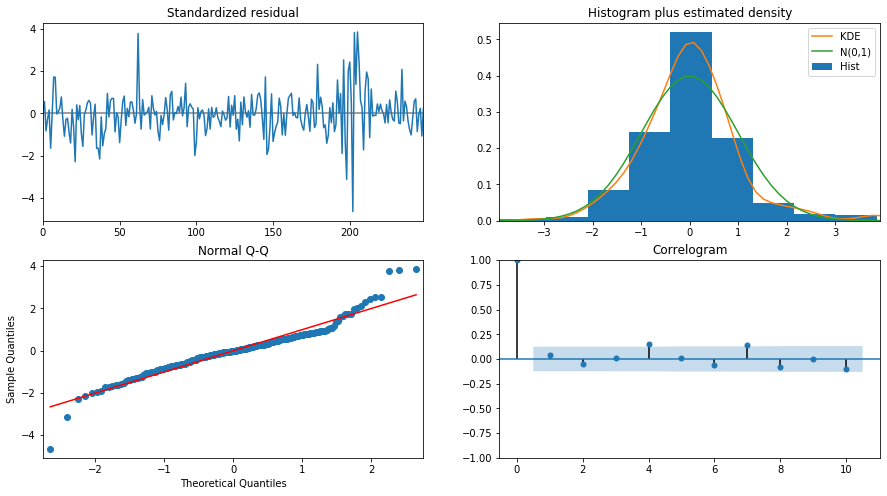

In [34]:
model_ARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

### LSTM

In [18]:
#scaling values to (0,1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_price = scaler.fit_transform(np.array(data_price).reshape(-1,1))

In [19]:
data_price.shape

(311, 1)

In [21]:
data_price[:5]

array([[0.98084517],
       [0.99957994],
       [1.        ],
       [0.98252541],
       [0.94421574]])

In [22]:
data.Year.value_counts()

2020    250
2021     61
Name: Year, dtype: int64

In [25]:
X = data.loc[data['Year']==2020]

In [28]:
Y = data.loc[data['Year']==2021]

In [29]:
Y

,Date,Price,Open,High,Low,Vol.,Change %,Year,Month,Week,Day,Dayofweek
0,2021-03-31,291.02,294,294.42,290.26,47.00M,-0.76%,2021,3,13,31,2
1,2021-03-30,293.25,294.86,295.72,291.5,38.81M,-0.02%,2021,3,13,30,1
2,2021-03-29,293.3,289.72,294.09,289.26,43.68M,0.71%,2021,3,13,29,0
3,2021-03-26,291.22,288.63,292.75,288.32,56.07M,1.59%,2021,3,12,26,4
4,2021-03-25,286.66,286.5,287.03,283.85,35.22M,0.30%,2021,3,12,25,3
...,...,...,...,...,...,...,...,...,...,...,...,...
56,2021-01-11,289.49,282.86,292.95,279.48,112.35M,2.06%,2021,1,2,11,0
57,2021-01-08,283.64,275.11,283.99,275.11,88.93M,3.92%,2021,1,1,8,4
58,2021-01-06,272.93,275.94,275.94,271.62,40.95M,-0.82%,2021,1,1,6,2
59,2021-01-05,275.2,272.69,275.7,270.28,45.58M,1.18%,2021,1,1,5,1
